In [22]:
import numpy as np
import scipy
import networkx as nx
import matplotlib.pyplot as plt

False


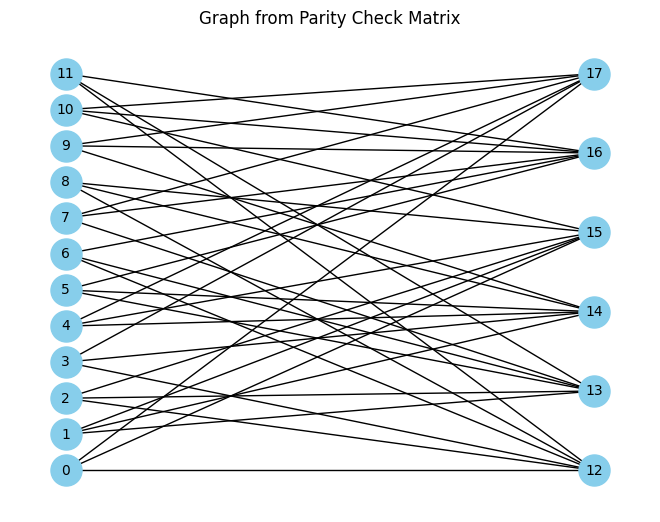

In [24]:
#The following parity check matrix is generated using Radford Neals LDPC-Codes Library
#./make-ldpc dummy 6 12 1 evenboth 3
binary_string = """ 1 0 1 1 0 0 1 0 1 0 0 1
                    0 1 1 0 0 1 1 1 0 0 0 1
                    0 1 0 1 1 1 0 0 1 1 0 0
                    1 1 1 0 1 0 0 0 1 0 1 0
                    0 0 0 0 0 1 1 1 0 1 1 1
                    1 0 0 1 1 0 0 1 0 1 1 0"""

H = np.array([[int(bit) for bit in line.split()] for line in binary_string.split('\n')])
print(scipy.sparse.issparse(H))

# Create a bipartite graph
G = nx.Graph()

# Determine the dimensions of the parity check matrix
num_checks, num_vars = H.shape

# Create variable nodes and check nodes
variable_nodes = list(range(num_vars))
check_nodes = list(range(num_vars, num_vars + num_checks))

# Add nodes to the graph
G.add_nodes_from(variable_nodes, bipartite=0)  # Variable nodes
G.add_nodes_from(check_nodes, bipartite=1)     # Check nodes

# Add edges between variable and check nodes based on the parity check matrix
for i in range(num_checks):
    for j in range(num_vars):
        if H[i, j] == 1:
            G.add_edge(j, num_vars + i)


pos = nx.bipartite_layout(G, variable_nodes)
nx.draw(G, pos, with_labels=True, node_size=500, node_color='skyblue', font_size=10, font_color='black')
plt.title("Graph from Parity Check Matrix")
plt.show()

In [42]:
#Code to Construct QLDPC Code From LDPC Code Following Construction given by Tillich and Zemor

#cartesian Product
def cp(a : list[int], b : list[int]):
    res = []
    for i in a:
        for j in b:
            res.append((i,j))
    return res

VxC = cp(variable_nodes,check_nodes)
CxV = cp(check_nodes,variable_nodes) 
VxVuCxC = cp(variable_nodes,variable_nodes) + cp(check_nodes,check_nodes)
Q = nx.strong_product(G,G)
print(len(Q.edges(VxC)))
print(len(Q.edges(CxV)))
len(Q.edges)
#Constructing the tripartiteGraph
subset_sizes = [len(VxC) , len(Q.nodes()) - 2*len(VxC), len(CxV)]
subset_color = ["red", "grey", "green"]


1944
1944


3888

In [47]:
len(Q.nodes())-72-72

180